In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
class SinusoidalEncoder(nn.Module):
    """Sinusoidal Positional Encoder used in Nerf."""

    def __init__(self, x_dim, min_deg, max_deg, use_identity: bool = True):
        super().__init__()
        self.x_dim = x_dim
        self.min_deg = min_deg
        self.max_deg = max_deg
        self.use_identity = use_identity
        self.register_buffer(
            "scales", torch.tensor([2**i for i in range(min_deg, max_deg)])
        )

    @property
    def latent_dim(self) -> int:
        return (
            int(self.use_identity) + (self.max_deg - self.min_deg) * 2
        ) * self.x_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [..., x_dim]
        Returns:
            latent: [..., latent_dim]
        """
        if self.max_deg == self.min_deg:
            return x
        xb = torch.reshape(
            (x[Ellipsis, None, :] * self.scales[:, None]),
            list(x.shape[:-1]) + [(self.max_deg - self.min_deg) * self.x_dim],
        )
        latent = torch.sin(torch.cat([xb, xb + 0.5 * math.pi], dim=-1))
        if self.use_identity:
            latent = torch.cat([x] + [latent], dim=-1)
        return latent

class DecoderMLPSkipConcat(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, num_hidden_layers, posenc=0) -> None:
        super().__init__()
        self.posenc = posenc
        if posenc > 0:
            self.PE = SinusoidalEncoder(in_channels, 0, posenc, use_identity=True)
            in_channels = self.PE.latent_dim
        first_layer_list = [nn.Linear(in_channels, hidden_channels), nn.ReLU()]
        for _ in range(num_hidden_layers // 2):
            first_layer_list.append(nn.Linear(hidden_channels, hidden_channels))
            first_layer_list.append(nn.ReLU())
        self.first_layers = nn.Sequential(*first_layer_list)
        
        second_layer_list = [nn.Linear(in_channels + hidden_channels, hidden_channels), nn.ReLU()]
        for _ in range(num_hidden_layers // 2 - 1):
            second_layer_list.append(nn.Linear(hidden_channels, hidden_channels))
            second_layer_list.append(nn.ReLU())
        second_layer_list.append(nn.Linear(hidden_channels, out_channels))
        self.second_layers = nn.Sequential(*second_layer_list)
    
    def forward(self, x):
        if self.posenc > 0:
            x = self.PE(x)
        h = self.first_layers(x)
        h = torch.cat([x, h], dim=-1)
        h = self.second_layers(h)
        return h


class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def compose_triplane_channelwise(feat_maps):
    h_xy, h_xz, h_yz = feat_maps # (H, W), (H, D), (W, D)
    assert h_xy.shape[1] == h_xz.shape[1] == h_yz.shape[1]
    C, H, W = h_xy.shape[-3:]
    D = h_xz.shape[-1]

    newH = max(H, W)
    newW = max(W, D)
    h_xy = F.pad(h_xy, (0, newW - W, 0, newH - H))
    h_xz = F.pad(h_xz, (0, newW - D, 0, newH - H))
    h_yz = F.pad(h_yz, (0, newW - D, 0, newH - W))
    h = torch.cat([h_xy, h_xz, h_yz], dim=1) # (B, 3C, H, W)

    return h, (H, W, D)


def decompose_triplane_channelwise(composed_map, sizes):
    H, W, D = sizes
    C = composed_map.shape[1] // 3
    h_xy = composed_map[:, :C, :H, :W]
    h_xz = composed_map[:, C:2*C, :H, :D]
    h_yz = composed_map[:, 2*C:, :W, :D]
    return h_xy, h_xz, h_yz


class TriplaneGroupResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up=False, ks=3, input_norm=True, input_act=True):
        super().__init__()
        in_channels *= 3
        out_channels *= 3

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.up = up
        
        self.input_norm = input_norm
        if input_norm and input_act:
            self.in_layers = nn.Sequential(
                # nn.GroupNorm(num_groups=3, num_channels=in_channels, eps=1e-6, affine=True),
                SiLU(),
                nn.Conv2d(in_channels, out_channels, groups=3, kernel_size=ks, stride=1, padding=(ks - 1)//2)
            )
        elif not input_norm:
            if input_act:
                self.in_layers = nn.Sequential(
                    SiLU(),
                    nn.Conv2d(in_channels, out_channels, groups=3, kernel_size=ks, stride=1, padding=(ks - 1)//2)
                )
            else:
                self.in_layers = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, groups=3, kernel_size=ks, stride=1, padding=(ks - 1)//2)
                )
        else:
            raise NotImplementedError

        self.norm_xy = nn.InstanceNorm2d(out_channels//3, eps=1e-6, affine=True)
        self.norm_xz = nn.InstanceNorm2d(out_channels//3, eps=1e-6, affine=True)
        self.norm_yz = nn.InstanceNorm2d(out_channels//3, eps=1e-6, affine=True)

        self.out_layers = nn.Sequential(
            # nn.GroupNorm(num_groups=3, num_channels=out_channels, eps=1e-6, affine=True),
            SiLU(),
            # nn.Dropout(p=dropout),
            zero_module(
                nn.Conv2d(out_channels, out_channels, groups=3, kernel_size=ks, stride=1, padding=(ks - 1)//2)
            ),
        )

        if self.in_channels != self.out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, groups=3, kernel_size=1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()

    def forward(self, feat_maps):
        if self.input_norm:
            feat_maps = [self.norm_xy(feat_maps[0]), self.norm_xz(feat_maps[1]), self.norm_yz(feat_maps[2])]
        x, (H, W, D) = compose_triplane_channelwise(feat_maps)

        if self.up:
            raise NotImplementedError
        else:
            h = self.in_layers(x)
        
        h_xy, h_xz, h_yz = decompose_triplane_channelwise(h, (H, W, D))
        h_xy = self.norm_xy(h_xy)
        h_xz = self.norm_xz(h_xz)
        h_yz = self.norm_yz(h_yz)
        h, _ = compose_triplane_channelwise([h_xy, h_xz, h_yz])

        h = self.out_layers(h)
        h = h + self.shortcut(x)
        h_maps = decompose_triplane_channelwise(h, (H, W, D))
        return h_maps

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, geo_feat_channels, z_down, padding_mode, kernel_size = (5, 5, 3), padding = (2, 2, 1)):
        super().__init__()
        self.z_down = z_down
        self.conv0 = nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, stride=(1, 1, 1), padding=padding, bias=True, padding_mode=padding_mode)
        self.convblock1 = nn.Sequential(
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, stride=(1, 1, 1), padding=padding, bias=True, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, stride=(1, 1, 1), padding=padding, bias=True, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels)
        )
        if self.z_down :
            self.downsample = nn.Sequential(
                nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 0, 0), bias=True, padding_mode=padding_mode),
                nn.InstanceNorm3d(geo_feat_channels)
            )
        else :
            self.downsample = nn.Sequential(
                nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2, 1, 2), stride=(2, 1, 2), padding=(0, 0, 0), bias=True, padding_mode=padding_mode),
                nn.InstanceNorm3d(geo_feat_channels)
            )
        self.convblock2 = nn.Sequential(
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, stride=(1, 1, 1), padding=padding, bias=True, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, stride=(1, 1, 1), padding=padding, bias=True, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels)
        )

    def forward(self, x):  # [b, geo_feat_channels, X, Y, Z]
        x = self.conv0(x)  # [b, geo_feat_channels, X, Y, Z]

        residual_feat = x
        x = self.convblock1(x)  # [b, geo_feat_channels, X, Y, Z]
        x = x + residual_feat   # [b, geo_feat_channels, X, Y, Z]
        x = self.downsample(x)  # [b, geo_feat_channels, X//2, Y//2, Z//2]

        residual_feat = x
        x = self.convblock2(x)
        x = x + residual_feat

        return x  # [b, geo_feat_channels, X//2, Y//2, Z//2]

class AutoEncoderGroupSkip(nn.Module):
    def __init__(self,
                 num_class=31,
                 geo_feat_channels=64,
                 feat_channel_up=64,
                 mlp_hidden_channels=128,
                 mlp_hidden_layers=4,
                 z_down=False,
                 padding_mode='zeros',
                 use_posenc=True):
        super().__init__()

        self.embedding = nn.Embedding(num_class, geo_feat_channels)
        self.geo_feat_dim = geo_feat_channels
        self.pos = use_posenc
        self.pos_num_freq = 6  # sinusoidal freq number

        print('✅ Building encoder...')
        self.geo_encoder = Encoder(geo_feat_channels, z_down, padding_mode, kernel_size=3, padding=1)

        self.norm = nn.InstanceNorm2d(geo_feat_channels)

        print('✅ Building triplane conv...')
        self.geo_convs = TriplaneGroupResnetBlock(geo_feat_channels, feat_channel_up, ks=3, input_norm=False, input_act=False)

        print('✅ Building decoder...')
        pe_dim = 6 * self.pos_num_freq if use_posenc else 0

        self.geo_decoder = DecoderMLPSkipConcat(feat_channel_up + pe_dim, num_class, mlp_hidden_channels, mlp_hidden_layers)

    def geo_parameters(self):
        return list(self.geo_encoder.parameters()) + list(self.geo_convs.parameters()) + list(self.geo_decoder.parameters())
    
    def tex_parameters(self):
        return list(self.tex_encoder.parameters()) + list(self.tex_convs.parameters()) + list(self.tex_decoder.parameters())

    def encode(self, vol):
        x = vol.detach().clone()
        x = torch.clamp(x, 0, self.embedding.num_embeddings - 1)
            
        x = self.embedding(x)# [B, D, H, W, C]
        x = x.permute(0, 4, 1, 2, 3)# → [B, C, D, H, W]
        vol_feat = self.geo_encoder(x)# → [B, C, D//2, H//2, W//2]

        xy_feat = vol_feat.mean(dim=4)
        xz_feat = vol_feat.mean(dim=3)
        yz_feat = vol_feat.mean(dim=2)
        
        xy_feat = (self.norm(xy_feat) * 0.5).tanh()
        xz_feat = (self.norm(xz_feat) * 0.5).tanh()
        yz_feat = (self.norm(yz_feat) * 0.5).tanh()
        return [xy_feat, xz_feat, yz_feat]
    
    def sample_feature_plane2D(self, feat_map, x):
        """Sample feature map at given coordinates"""
        # feat_map: [bs, C, H, W]
        # x: [bs, N, 2]
        sample_coords = x.view(x.shape[0], 1, -1, 2) # sample_coords: [bs, 1, N, 2]
        feat = F.grid_sample(feat_map, sample_coords.flip(-1), align_corners=False, padding_mode='border') # feat : [bs, C, 1, N]
        feat = feat[:, :, 0, :] # feat : [bs, C, N]
        feat = feat.transpose(1, 2) # feat : [bs, N, C]
        return feat


    def decode(self, feat_maps, query):        

            # coords [N, 3]
        coords_list = [[0, 1], [0, 2], [1, 2]]
        geo_feat_maps = [fm[:, :self.geo_feat_dim] for fm in feat_maps]
        geo_feat_maps = self.geo_convs(geo_feat_maps)

     
        h_geo = 0
        for i in range(3):
            h_geo += self.sample_feature_plane2D(geo_feat_maps[i], query[..., coords_list[i]]) # feat : [bs, N, C]
      
        if self.pos :
            # multiply_PE_res = 1
            # embed_fn, input_ch = get_embedder(multires=multiply_PE_res)
            # sample_PE = embed_fn(query)
            PE = []
            for freq in range(self.pos_num_freq):
                PE.append(torch.sin((2.**freq) * query))
                PE.append(torch.cos((2.**freq) * query))

            PE = torch.cat(PE, dim=-1)  # [bs, N, 6*self.pos_num_freq]
            h_geo = torch.cat([h_geo, PE], dim=-1)

        h = self.geo_decoder(h_geo) # h : [bs, N, 1]
        return h
    
    def forward(self, vol, query):
        feat_map = self.encode(vol)
        return self.decode(feat_map, query)

In [3]:
import torch

from torch.autograd import Variable
import torch.nn.functional as F
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse as ifilterfalse



# -*- coding:utf-8 -*-
# author: Xinge

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=11):
    dice=0
    for index in range(1, numLabels):
        dice += dice_coef(y_true[:,index,:,:,:], y_pred[:,index,:,:,:])
    return (numLabels-1) - dice

"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

# --------------------------- MULTICLASS LOSSES ---------------------------


def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch and removes ignored entries
    """
    if probas.dim() == 3:
        B, H, W = probas.size()
        probas = probas.view(B, 1, H, W)
    elif probas.dim() == 5:
        B, C, L, H, W = probas.size()
        probas = probas.contiguous().view(B, C, L, H*W)

    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)
    labels = labels.view(-1)

    if ignore is None:
        return probas, labels

    valid = (labels != ignore)
    if valid.sum() == 0:
        return probas.new_zeros((0, C)), labels.new_zeros((0,), dtype=torch.long)

    vprobas = probas[valid]
    vlabels = labels[valid]
    return vprobas, vlabels



# --------------------------- HELPER FUNCTIONS ---------------------------
def isnan(x):
    return x != x
    
    
def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

<>:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Admin\AppData\Local\Temp\ipykernel_20632\625430603.py:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (classes is 'present' and fg.sum() == 0):


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm



# ==== 设置参数 ====
NUM_CLASSES = 31
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoderGroupSkip(
    num_class=NUM_CLASSES,
    geo_feat_channels=64,
    feat_channel_up=64,
    mlp_hidden_channels=128,
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ce_loss = nn.CrossEntropyLoss(ignore_index=255)  # ignore index if needed
scaler = torch.cuda.amp.GradScaler()

# # ==== 模拟数据集 ====
# # 你需要提供: (vox: [B,D,H,W], query: [B,N,3], label: [B,N], coord: [B,N,3])
# # 用你自己 Dataset 替换这个部分
# class DummyDataset(torch.utils.data.Dataset):
#     def __len__(self):
#         return 1000
#     def __getitem__(self, idx):
#         D, H, W = 16, 12, 16
#         vox = torch.randint(0, NUM_CLASSES, (D, H, W))      # patch label
#         query = torch.rand(1024, 3) * 2 - 1                  # coords in [-1,1]
#         label = torch.randint(0, NUM_CLASSES, (1024,))       # label in range
#         coord = torch.stack([
#             torch.randint(0, D, (1024,)),
#             torch.randint(0, H, (1024,)),
#             torch.randint(0, W, (1024,))
#         ], dim=1)
#         return vox, query, label, coord
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
class VoxelPatchDataset(Dataset):
    def __init__(self, root_dir, num_query=1024):
        self.paths = list(Path(root_dir).rglob("patch_*.npy"))
        self.num_query = num_query

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        voxel = np.load(self.paths[idx])  # [16, 12, 16]
        
        # 随机 y 旋转（x-z 平面）
        k = np.random.randint(0, 4)
        voxel = np.rot90(voxel, k=k, axes=(0, 2)).copy()

        voxel_tensor = torch.tensor(voxel, dtype=torch.long)  # [D, H, W]
        D, H, W = voxel_tensor.shape

        # === 随机采样 query 点坐标（world 空间归一化到 [-1, 1]）
        coords = torch.stack([
            torch.randint(0, D, (self.num_query,)),
            torch.randint(0, H, (self.num_query,)),
            torch.randint(0, W, (self.num_query,))
        ], dim=1)  # [N, 3]

        # label 为 query 对应位置的 voxel 值
        label = voxel_tensor[coords[:, 0], coords[:, 1], coords[:, 2]]  # [N]
        
        # world 坐标归一化到 [-1, 1]（跟解码器坐标输入一致）
        query = coords.clone().float()
        query[:, 0] = query[:, 0] / (D - 1) * 2 - 1
        query[:, 1] = query[:, 1] / (H - 1) * 2 - 1
        query[:, 2] = query[:, 2] / (W - 1) * 2 - 1

        return voxel_tensor, query, label, coords
dataset = VoxelPatchDataset("dataset")
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

# ==== 训练循环 ====
for epoch in range(10):
    model.train()
    pbar = tqdm(train_loader)
    total_loss, total_iou = 0, 0

    for vox, query, label, coord in pbar:
        vox = vox.to(device).long()
        query = query.to(device).float()
        label = label.to(device).long()
        # 🧪 检查合法性（提前发现错误）
        if not torch.all((label >= 0) & (label < NUM_CLASSES)):
            print("❌ Invalid label range detected! min:", label.min().item(), "max:", label.max().item())
            raise ValueError("label out of range")

        coord = coord.to(device).long()
        assert label.min() >= 0 and label.max() <= NUM_CLASSES or label.max() == 255

        coord = coord.to(device).long()

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            pred = model(vox, query)  # [B, N, C]
            ce = ce_loss(pred.view(-1, NUM_CLASSES), label.view(-1))
            
            # Lovasz part
            B, D, H, W = vox.shape
            # 假设 pred: [B, N, C] softmax logit
            pred_soft = torch.softmax(pred, dim=-1)  # [B, N, C]
            B, D, H, W = vox.shape
            pred_3d = torch.zeros(B, NUM_CLASSES, D, H, W, device=device)
            label_3d = torch.full((B, D, H, W), 255, device=device)

            for b in range(B):
                x, y, z = coord[b].T
                pred_3d[b, :, x, y, z] = pred_soft[b].T
                label_3d[b, x, y, z] = label[b]

            # === 转换为 CPU safe flat tensors ===
            pred_flat = pred_3d.permute(0, 2, 3, 4, 1).contiguous().view(-1, NUM_CLASSES)  # [N, C]
            label_flat = label_3d.view(-1)  # [N]
            valid = (label_flat != 255)

            if valid.sum() == 0:
                lovasz = torch.tensor(0.0, device=device)
            else:
                pred_valid = pred_flat[valid].cpu()
                label_valid = label_flat[valid].cpu()
                lovasz = lovasz_softmax_flat(pred_valid, label_valid, classes='present').to(device)
            loss = ce + lovasz

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

    print(f"✅ Epoch {epoch+1} done. Avg loss = {total_loss / len(train_loader):.4f}")


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_13892\276441545.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/20206 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_13892\276441545.py:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 Loss: 0.0982: 100%|██████████| 20206/20206 [31:12<00:00, 10.79it/s]


✅ Epoch 1 done. Avg loss = 0.2129


Epoch 2 Loss: 0.1469: 100%|██████████| 20206/20206 [15:35<00:00, 21.61it/s]


✅ Epoch 2 done. Avg loss = 0.0683


Epoch 3 Loss: 0.0434: 100%|██████████| 20206/20206 [23:22<00:00, 14.40it/s]


✅ Epoch 3 done. Avg loss = 0.0507


Epoch 4 Loss: 0.0102: 100%|██████████| 20206/20206 [11:18<00:00, 29.78it/s]


✅ Epoch 4 done. Avg loss = 0.0412


Epoch 5 Loss: 0.0079: 100%|██████████| 20206/20206 [11:06<00:00, 30.34it/s]


✅ Epoch 5 done. Avg loss = 0.0362


Epoch 6 Loss: 0.0385: 100%|██████████| 20206/20206 [14:17<00:00, 23.57it/s]


✅ Epoch 6 done. Avg loss = 0.0328


Epoch 7 Loss: 0.0131: 100%|██████████| 20206/20206 [17:15<00:00, 19.51it/s]


✅ Epoch 7 done. Avg loss = 0.0304


Epoch 8 Loss: 0.0417: 100%|██████████| 20206/20206 [11:13<00:00, 30.02it/s]


✅ Epoch 8 done. Avg loss = 0.0278


Epoch 9 Loss: 0.0001: 100%|██████████| 20206/20206 [11:18<00:00, 29.78it/s]


✅ Epoch 9 done. Avg loss = 0.0262


Epoch 10 Loss: 0.0136: 100%|██████████| 20206/20206 [11:25<00:00, 29.47it/s]

✅ Epoch 10 done. Avg loss = 0.0255


In [8]:
torch.save(model.state_dict(), f"ae_triplane_.pt")


In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ==== 加载模型 ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=64,
    feat_channel_up=64,
    mlp_hidden_channels=128,
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)
model.load_state_dict(torch.load("ae_triplane_.pt", map_location=device))
model.eval()

# ==== 可视化工具 ====
def visualize_voxel(ax, label, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # XZY
    filled = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~filled] = [0, 0, 0, 0]
    ax.voxels(filled, facecolors=facecolors, edgecolor='k', linewidth=0.2)
    ax.set_title(title)
    ax.axis('off')

# ==== 加载随机 patch，重建并可视化 ====
paths = list(Path("dataset").rglob("patch_*.npy"))
samples = np.random.choice(paths, size=10, replace=False)

fig = plt.figure(figsize=(20, 6))

for i, path in enumerate(samples):
    voxel = np.load(path)
    vox_tensor = torch.tensor(voxel, dtype=torch.long).unsqueeze(0).to(device)

    # === 生成 query 网格 ===
    D, H, W = 16, 12, 16
    coords = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, D),
        torch.linspace(-1, 1, H),
        torch.linspace(-1, 1, W),
        indexing='ij'), dim=-1).reshape(-1, 3).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(vox_tensor, coords)  # [1, D*H*W, C]
        pred = logits.argmax(dim=-1).view(D, H, W).cpu().numpy()

    ax = fig.add_subplot(2, 10, i+1, projection='3d')
    visualize_voxel(ax, voxel, f"Original {i+1}")

    ax = fig.add_subplot(2, 10, i+11, projection='3d')
    visualize_voxel(ax, pred, f"Reconstructed {i+1}")

plt.tight_layout()
plt.show()


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_21420\3311463340.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ae_triplane_.pt", map_loc

RuntimeError: Error(s) in loading state_dict for AutoEncoderGroupSkip:
	size mismatch for geo_encoder.downsample.0.weight: copying a param with shape torch.Size([64, 64, 2, 2, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 2, 1, 2]).

In [24]:
# 假设你已经有一个 voxel patch 数据
voxel = torch.randint(0, 31, (1, 16, 12, 16)).to(device)  # [B, D, H, W]

# 前向编码
model.eval()
with torch.no_grad():
    triplanes = model.encode(voxel)  # List of 3 feature maps

# 打印每一张平面的 shape
for i, plane in enumerate(triplanes):
    print(f"Triplane {i}: {plane.shape}")


Triplane 0: torch.Size([1, 64, 8, 12])
Triplane 1: torch.Size([1, 64, 8, 8])
Triplane 2: torch.Size([1, 64, 12, 8])


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm



# ==== 设置参数 ====
NUM_CLASSES = 31
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=16,  # or 32
    feat_channel_up=16,
    mlp_hidden_channels=64,  #
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ce_loss = nn.CrossEntropyLoss(ignore_index=255)  # ignore index if needed
scaler = torch.cuda.amp.GradScaler()

# ==== 模拟数据集 ====
# 你需要提供: (vox: [B,D,H,W], query: [B,N,3], label: [B,N], coord: [B,N,3])
# 用你自己 Dataset 替换这个部分
class DummyDataset(torch.utils.data.Dataset):
    def __len__(self):
        return 1000
    def __getitem__(self, idx):
        D, H, W = 16, 12, 16
        vox = torch.randint(0, NUM_CLASSES, (D, H, W))      # patch label
        query = torch.rand(1024, 3) * 2 - 1                  # coords in [-1,1]
        label = torch.randint(0, NUM_CLASSES, (1024,))       # label in range
        coord = torch.stack([
            torch.randint(0, D, (1024,)),
            torch.randint(0, H, (1024,)),
            torch.randint(0, W, (1024,))
        ], dim=1)
        return vox, query, label, coord
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
class VoxelPatchDataset(Dataset):
    def __init__(self, root_dir, num_query=1024):
        self.paths = list(Path(root_dir).rglob("patch_*.npy"))
        self.num_query = num_query

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        voxel = np.load(self.paths[idx])  # [16, 12, 16]
        
        # 随机 y 旋转（x-z 平面）
        k = np.random.randint(0, 4)
        voxel = np.rot90(voxel, k=k, axes=(0, 2)).copy()

        voxel_tensor = torch.tensor(voxel, dtype=torch.long)  # [D, H, W]
        D, H, W = voxel_tensor.shape

        # === 随机采样 query 点坐标（world 空间归一化到 [-1, 1]）
        coords = torch.stack([
            torch.randint(0, D, (self.num_query,)),
            torch.randint(0, H, (self.num_query,)),
            torch.randint(0, W, (self.num_query,))
        ], dim=1)  # [N, 3]

        # label 为 query 对应位置的 voxel 值
        label = voxel_tensor[coords[:, 0], coords[:, 1], coords[:, 2]]  # [N]
        
        # world 坐标归一化到 [-1, 1]（跟解码器坐标输入一致）
        query = coords.clone().float()
        query[:, 0] = query[:, 0] / (D - 1) * 2 - 1
        query[:, 1] = query[:, 1] / (H - 1) * 2 - 1
        query[:, 2] = query[:, 2] / (W - 1) * 2 - 1

        return voxel_tensor, query, label, coords
dataset = VoxelPatchDataset("dataset")
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)
# 加载模型
model.load_state_dict(torch.load("ae_triplane_epoch13.pt"))
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)  # 原来 1e-3 → 现在 5e-4

# ==== 训练循环 ====
for epoch in range(13,20):
    model.train()
    pbar = tqdm(train_loader)
    total_loss, total_iou = 0, 0

    for vox, query, label, coord in pbar:
        vox = vox.to(device).long()
        query = query.to(device).float()
        label = label.to(device).long()
        # 🧪 检查合法性（提前发现错误）
        if not torch.all((label >= 0) & (label < NUM_CLASSES)):
            print("❌ Invalid label range detected! min:", label.min().item(), "max:", label.max().item())
            raise ValueError("label out of range")

        coord = coord.to(device).long()
        assert label.min() >= 0 and label.max() <= NUM_CLASSES or label.max() == 255

        coord = coord.to(device).long()

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            pred = model(vox, query)  # [B, N, C]
            ce = ce_loss(pred.view(-1, NUM_CLASSES), label.view(-1))
            
            # Lovasz part
            B, D, H, W = vox.shape
            # 假设 pred: [B, N, C] softmax logit
            pred_soft = torch.softmax(pred, dim=-1)  # [B, N, C]
            B, D, H, W = vox.shape
            pred_3d = torch.zeros(B, NUM_CLASSES, D, H, W, device=device)
            label_3d = torch.full((B, D, H, W), 255, device=device)

            for b in range(B):
                x, y, z = coord[b].T
                pred_3d[b, :, x, y, z] = pred_soft[b].T
                label_3d[b, x, y, z] = label[b]

            # === 转换为 CPU safe flat tensors ===
            pred_flat = pred_3d.permute(0, 2, 3, 4, 1).contiguous().view(-1, NUM_CLASSES)  # [N, C]
            label_flat = label_3d.view(-1)  # [N]
            valid = (label_flat != 255)

            if valid.sum() == 0:
                lovasz = torch.tensor(0.0, device=device)
            else:
                pred_valid = pred_flat[valid].cpu()
                label_valid = label_flat[valid].cpu()
                lovasz = lovasz_softmax_flat(pred_valid, label_valid, classes='present').to(device)
            loss = ce + lovasz

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")
    torch.save(model.state_dict(), f"ae_triplane_epoch{epoch+1}.pt")
    print(f"✅ Epoch {epoch+1} done. Avg loss = {total_loss / len(train_loader):.4f}")


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_19004\3976490146.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\Admin\AppData\Local\Temp\ipykernel_19004\3976490146.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `w

✅ Epoch 14 done. Avg loss = 0.0347


Epoch 15 Loss: 0.0157: 100%|██████████| 20206/20206 [10:01<00:00, 33.62it/s]


✅ Epoch 15 done. Avg loss = 0.0330


Epoch 16 Loss: 0.0023: 100%|██████████| 20206/20206 [10:05<00:00, 33.39it/s]


✅ Epoch 16 done. Avg loss = 0.0319


Epoch 17 Loss: 0.0151: 100%|██████████| 20206/20206 [10:07<00:00, 33.27it/s]


✅ Epoch 17 done. Avg loss = 0.0314


Epoch 18 Loss: 0.0141: 100%|██████████| 20206/20206 [10:12<00:00, 33.01it/s]


✅ Epoch 18 done. Avg loss = 0.0310


Epoch 19 Loss: 0.0361: 100%|██████████| 20206/20206 [10:13<00:00, 32.96it/s]


✅ Epoch 19 done. Avg loss = 0.0306


Epoch 20 Loss: 0.0061: 100%|██████████| 20206/20206 [10:19<00:00, 32.59it/s]

✅ Epoch 20 done. Avg loss = 0.0300


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_21420\1280662861.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ae_triplane_epoch20.pt", 

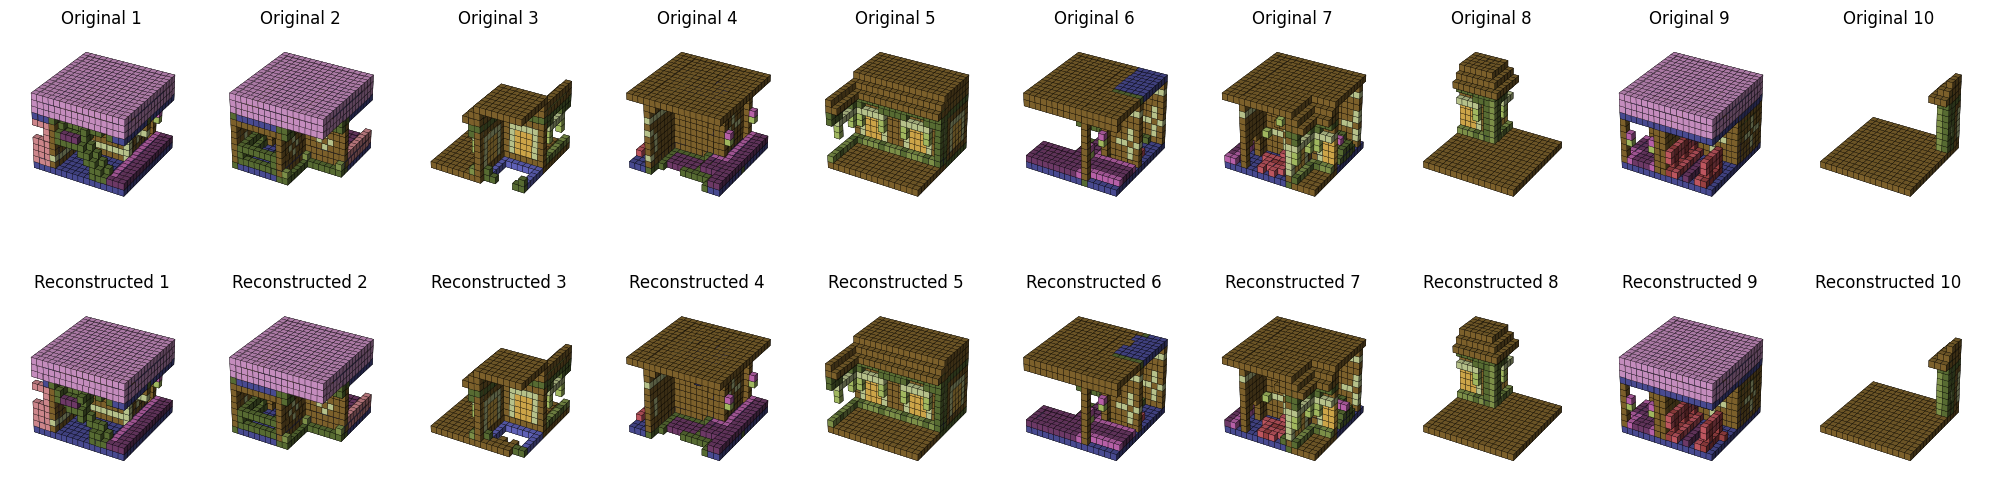

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ==== 加载模型 ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=16,  # or 32
    feat_channel_up=16,
    mlp_hidden_channels=64,  #
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)
model.load_state_dict(torch.load("ae_triplane_epoch20.pt", map_location=device))
model.eval()

# ==== 可视化工具 ====
def visualize_voxel(ax, label, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # XZY
    filled = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~filled] = [0, 0, 0, 0]
    ax.voxels(filled, facecolors=facecolors, edgecolor='k', linewidth=0.2)
    ax.set_title(title)
    ax.axis('off')

# ==== 加载随机 patch，重建并可视化 ====
paths = list(Path("dataset").rglob("patch_*.npy"))
samples = np.random.choice(paths, size=10, replace=False)

fig = plt.figure(figsize=(20, 6))

for i, path in enumerate(samples):
    voxel = np.load(path)
    vox_tensor = torch.tensor(voxel, dtype=torch.long).unsqueeze(0).to(device)

    # === 生成 query 网格 ===
    D, H, W = 16, 12, 16
    coords = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, D),
        torch.linspace(-1, 1, H),
        torch.linspace(-1, 1, W),
        indexing='ij'), dim=-1).reshape(-1, 3).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(vox_tensor, coords)  # [1, D*H*W, C]
        pred = logits.argmax(dim=-1).view(D, H, W).cpu().numpy()

    ax = fig.add_subplot(2, 10, i+1, projection='3d')
    visualize_voxel(ax, voxel, f"Original {i+1}")

    ax = fig.add_subplot(2, 10, i+11, projection='3d')
    visualize_voxel(ax, pred, f"Reconstructed {i+1}")

plt.tight_layout()
plt.show()


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_19004\164843371.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ae_triplane_epoch20.pt", m

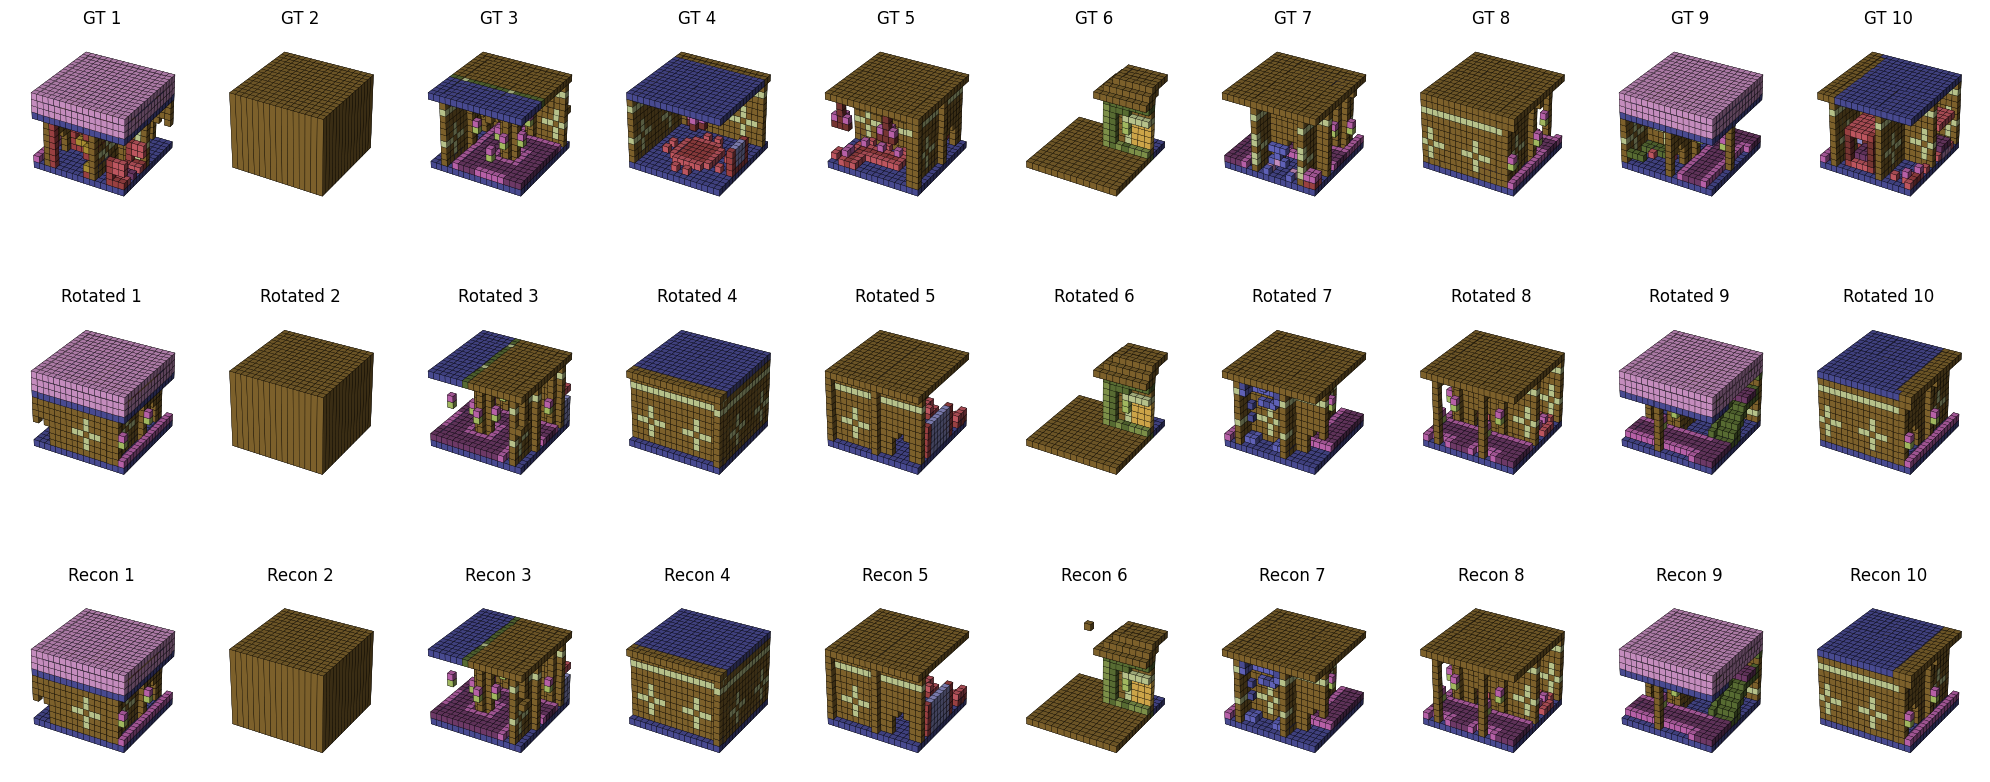

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ==== 加载模型 ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=16,
    feat_channel_up=16,
    mlp_hidden_channels=64,
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)
model.load_state_dict(torch.load("ae_triplane_epoch20.pt", map_location=device))
model.eval()

# ==== 可视化工具 ====
def visualize_voxel(ax, label, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # XZY
    filled = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~filled] = [0, 0, 0, 0]
    ax.voxels(filled, facecolors=facecolors, edgecolor='k', linewidth=0.2)
    ax.set_title(title)
    ax.axis('off')

# ==== 加载随机 patch，重建并可视化 ====
paths = list(Path("dataset").rglob("patch_*.npy"))
samples = np.random.choice(paths, size=10, replace=False)

fig = plt.figure(figsize=(20, 9))  # 增高一行

for i, path in enumerate(samples):
    voxel = np.load(path)

    # === 原始 ===
    ax1 = fig.add_subplot(3, 10, i + 1, projection='3d')
    visualize_voxel(ax1, voxel, f"GT {i+1}")

    # === 随机旋转（绕 y） ===
    k = np.random.randint(0, 4)
    rotated = np.rot90(voxel, k=k, axes=(0, 2)).copy()

    ax2 = fig.add_subplot(3, 10, i + 1 + 10, projection='3d')
    visualize_voxel(ax2, rotated, f"Rotated {i+1}")

    # === 编码后解码 ===
    vox_tensor = torch.tensor(rotated, dtype=torch.long).unsqueeze(0).to(device)

    D, H, W = 16, 12, 16
    coords = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, D),
        torch.linspace(-1, 1, H),
        torch.linspace(-1, 1, W),
        indexing='ij'), dim=-1).reshape(-1, 3).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(vox_tensor, coords)
        pred = logits.argmax(dim=-1).view(D, H, W).cpu().numpy()

    ax3 = fig.add_subplot(3, 10, i + 1 + 20, projection='3d')
    visualize_voxel(ax3, pred, f"Recon {i+1}")

plt.tight_layout()
plt.show()


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=16,  # or 32
    feat_channel_up=16,
    mlp_hidden_channels=64,  #
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)
# 假设你已经有一个 voxel patch 数据
voxel = torch.randint(0, 31, (1, 16, 12, 16)).to(device)  # [B, D, H, W]

# 前向编码
model.eval()
with torch.no_grad():
    triplanes = model.encode(voxel)  # List of 3 feature maps

# 打印每一张平面的 shape
for i, plane in enumerate(triplanes):
    print(f"Triplane {i}: {plane.shape}")


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...
Triplane 0: torch.Size([1, 16, 8, 12])
Triplane 1: torch.Size([1, 16, 8, 8])
Triplane 2: torch.Size([1, 16, 12, 8])


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
from pathlib import Path
import numpy as np

# ==== 参数设置 ====
NUM_CLASSES = 31
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== 构建模型 ====
model = AutoEncoderGroupSkip(
    num_class=NUM_CLASSES,
    geo_feat_channels=16,
    feat_channel_up=16,
    mlp_hidden_channels=64,
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=5e-5)  # Cosine scheduler

ce_loss = nn.CrossEntropyLoss(ignore_index=255)
scaler = torch.cuda.amp.GradScaler()

# ==== 数据集 ====
class VoxelPatchDataset(Dataset):
    def __init__(self, root_dir, num_query=1024):
        self.paths = list(Path(root_dir).rglob("patch_*.npy"))
        self.num_query = num_query

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        voxel = np.load(self.paths[idx])  # [16, 12, 16]
        k = np.random.randint(0, 4)
        voxel = np.rot90(voxel, k=k, axes=(0, 2)).copy()

        voxel_tensor = torch.tensor(voxel, dtype=torch.long)
        D, H, W = voxel_tensor.shape
        coords = torch.stack([
            torch.randint(0, D, (self.num_query,)),
            torch.randint(0, H, (self.num_query,)),
            torch.randint(0, W, (self.num_query,))
        ], dim=1)
        label = voxel_tensor[coords[:, 0], coords[:, 1], coords[:, 2]]

        query = coords.clone().float()
        query[:, 0] = query[:, 0] / (D - 1) * 2 - 1
        query[:, 1] = query[:, 1] / (H - 1) * 2 - 1
        query[:, 2] = query[:, 2] / (W - 1) * 2 - 1

        return voxel_tensor, query, label, coords

dataset = VoxelPatchDataset("dataset")
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

# ==== 训练循环 ====
for epoch in range(20):
    model.train()
    pbar = tqdm(train_loader)
    total_loss = 0

    for vox, query, label, coord in pbar:
        vox = vox.to(device).long()
        query = query.to(device).float()
        label = label.to(device).long()
        coord = coord.to(device).long()

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            pred = model(vox, query)
            ce = ce_loss(pred.view(-1, NUM_CLASSES), label.view(-1))

            # Lovasz
            B, D, H, W = vox.shape
            pred_soft = torch.softmax(pred, dim=-1)
            pred_3d = torch.zeros(B, NUM_CLASSES, D, H, W, device=device)
            label_3d = torch.full((B, D, H, W), 255, device=device)
            for b in range(B):
                x, y, z = coord[b].T
                pred_3d[b, :, x, y, z] = pred_soft[b].T
                label_3d[b, x, y, z] = label[b]
            pred_flat = pred_3d.permute(0, 2, 3, 4, 1).contiguous().view(-1, NUM_CLASSES)
            label_flat = label_3d.view(-1)
            valid = (label_flat != 255)

            if valid.sum() == 0:
                lovasz = torch.tensor(0.0, device=device)
            else:
                pred_valid = pred_flat[valid].cpu()
                label_valid = label_flat[valid].cpu()
                lovasz = lovasz_softmax_flat(pred_valid, label_valid, classes='present').to(device)
            loss = ce + lovasz

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

    scheduler.step()
    torch.save(model.state_dict(), f"ae_triplane_epoch{epoch+1}.pt")
    print(f"✅ Epoch {epoch+1} done. Avg loss = {total_loss / len(train_loader):.4f} | LR = {scheduler.get_last_lr()[0]:.6e}")


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_21420\3051697983.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/20206 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_21420\3051697983.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 Loss: 0.2463: 100%|██████████| 20206/20206 [16:31<00:00, 20.39it/s]


✅ Epoch 1 done. Avg loss = 0.4670 | LR = 9.941520e-04


Epoch 2 Loss: 0.1142: 100%|██████████| 20206/20206 [09:42<00:00, 34.67it/s]


✅ Epoch 2 done. Avg loss = 0.2562 | LR = 9.767518e-04


Epoch 3 Loss: 0.2135: 100%|██████████| 20206/20206 [09:47<00:00, 34.38it/s]


✅ Epoch 3 done. Avg loss = 0.1824 | LR = 9.482281e-04


Epoch 4 Loss: 0.1304: 100%|██████████| 20206/20206 [09:56<00:00, 33.86it/s]


✅ Epoch 4 done. Avg loss = 0.1524 | LR = 9.092831e-04


Epoch 5 Loss: 0.1673: 100%|██████████| 20206/20206 [10:20<00:00, 32.58it/s]


✅ Epoch 5 done. Avg loss = 0.1338 | LR = 8.608757e-04


Epoch 6 Loss: 0.1347: 100%|██████████| 20206/20206 [10:24<00:00, 32.38it/s]


✅ Epoch 6 done. Avg loss = 0.1204 | LR = 8.041980e-04


Epoch 7 Loss: 0.0896: 100%|██████████| 20206/20206 [11:07<00:00, 30.26it/s]


✅ Epoch 7 done. Avg loss = 0.1108 | LR = 7.406455e-04


Epoch 8 Loss: 0.0730: 100%|██████████| 20206/20206 [11:11<00:00, 30.08it/s]


✅ Epoch 8 done. Avg loss = 0.1018 | LR = 6.717831e-04


Epoch 9 Loss: 0.0873: 100%|██████████| 20206/20206 [10:24<00:00, 32.34it/s]


✅ Epoch 9 done. Avg loss = 0.0945 | LR = 5.993064e-04


Epoch 10 Loss: 0.0393: 100%|██████████| 20206/20206 [09:40<00:00, 34.81it/s]


✅ Epoch 10 done. Avg loss = 0.0881 | LR = 5.250000e-04


Epoch 11 Loss: 0.2164: 100%|██████████| 20206/20206 [09:45<00:00, 34.53it/s]


✅ Epoch 11 done. Avg loss = 0.0820 | LR = 4.506936e-04


Epoch 12 Loss: 0.1112: 100%|██████████| 20206/20206 [09:42<00:00, 34.68it/s]


✅ Epoch 12 done. Avg loss = 0.0762 | LR = 3.782169e-04


Epoch 13 Loss: 0.0325: 100%|██████████| 20206/20206 [09:49<00:00, 34.27it/s]


✅ Epoch 13 done. Avg loss = 0.0717 | LR = 3.093545e-04


Epoch 14 Loss: 0.0778: 100%|██████████| 20206/20206 [09:45<00:00, 34.51it/s]


✅ Epoch 14 done. Avg loss = 0.0672 | LR = 2.458020e-04


Epoch 15 Loss: 0.0667: 100%|██████████| 20206/20206 [09:44<00:00, 34.57it/s]


✅ Epoch 15 done. Avg loss = 0.0632 | LR = 1.891243e-04


Epoch 16 Loss: 0.0615: 100%|██████████| 20206/20206 [09:43<00:00, 34.64it/s]


✅ Epoch 16 done. Avg loss = 0.0598 | LR = 1.407169e-04


Epoch 17 Loss: 0.0229: 100%|██████████| 20206/20206 [09:39<00:00, 34.85it/s]


✅ Epoch 17 done. Avg loss = 0.0571 | LR = 1.017719e-04


Epoch 18 Loss: 0.0448: 100%|██████████| 20206/20206 [09:44<00:00, 34.60it/s]


✅ Epoch 18 done. Avg loss = 0.0551 | LR = 7.324815e-05


Epoch 19 Loss: 0.0204: 100%|██████████| 20206/20206 [09:46<00:00, 34.43it/s]


✅ Epoch 19 done. Avg loss = 0.0532 | LR = 5.584804e-05


Epoch 20 Loss: 0.0604: 100%|██████████| 20206/20206 [09:50<00:00, 34.24it/s]

✅ Epoch 20 done. Avg loss = 0.0520 | LR = 5.000000e-05


In [10]:
# 假设你已经有一个 voxel patch 数据
voxel = torch.randint(0, 31, (1, 16, 12, 16)).to(device)  # [B, D, H, W]

# 前向编码
model.eval()
with torch.no_grad():
    triplanes = model.encode(voxel)  # List of 3 feature maps

# 打印每一张平面的 shape
for i, plane in enumerate(triplanes):
    print(f"Triplane {i}: {plane.shape}")


Triplane 0: torch.Size([1, 16, 8, 12])
Triplane 1: torch.Size([1, 16, 8, 8])
Triplane 2: torch.Size([1, 16, 12, 8])


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_21420\1280662861.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ae_triplane_epoch20.pt", 

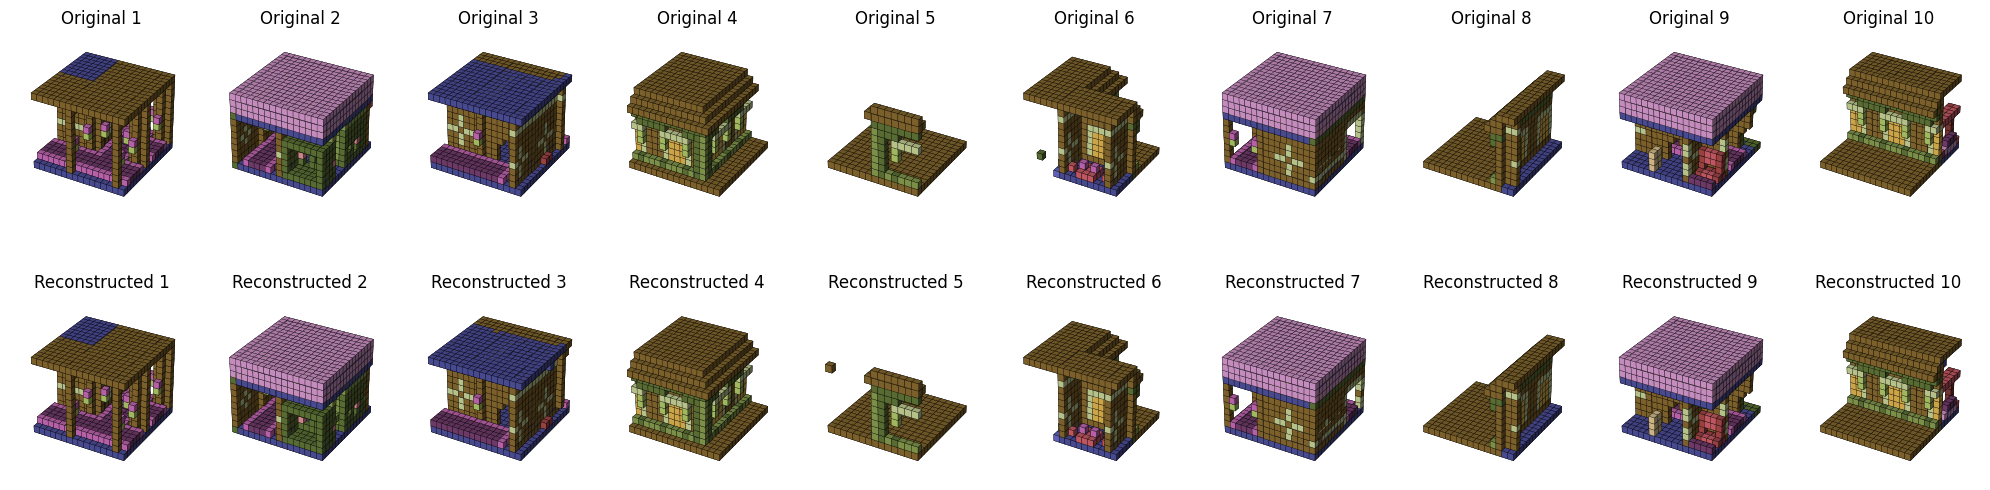

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ==== 加载模型 ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=16,  # or 32
    feat_channel_up=16,
    mlp_hidden_channels=64,  #
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)
model.load_state_dict(torch.load("ae_triplane_epoch20.pt", map_location=device))
model.eval()

# ==== 可视化工具 ====
def visualize_voxel(ax, label, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # XZY
    filled = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~filled] = [0, 0, 0, 0]
    ax.voxels(filled, facecolors=facecolors, edgecolor='k', linewidth=0.2)
    ax.set_title(title)
    ax.axis('off')

# ==== 加载随机 patch，重建并可视化 ====
paths = list(Path("dataset").rglob("patch_*.npy"))
samples = np.random.choice(paths, size=10, replace=False)

fig = plt.figure(figsize=(20, 6))

for i, path in enumerate(samples):
    voxel = np.load(path)
    vox_tensor = torch.tensor(voxel, dtype=torch.long).unsqueeze(0).to(device)

    # === 生成 query 网格 ===
    D, H, W = 16, 12, 16
    coords = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, D),
        torch.linspace(-1, 1, H),
        torch.linspace(-1, 1, W),
        indexing='ij'), dim=-1).reshape(-1, 3).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(vox_tensor, coords)  # [1, D*H*W, C]
        pred = logits.argmax(dim=-1).view(D, H, W).cpu().numpy()

    ax = fig.add_subplot(2, 10, i+1, projection='3d')
    visualize_voxel(ax, voxel, f"Original {i+1}")

    ax = fig.add_subplot(2, 10, i+11, projection='3d')
    visualize_voxel(ax, pred, f"Reconstructed {i+1}")

plt.tight_layout()
plt.show()


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_21420\164843371.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ae_triplane_epoch20.pt", m

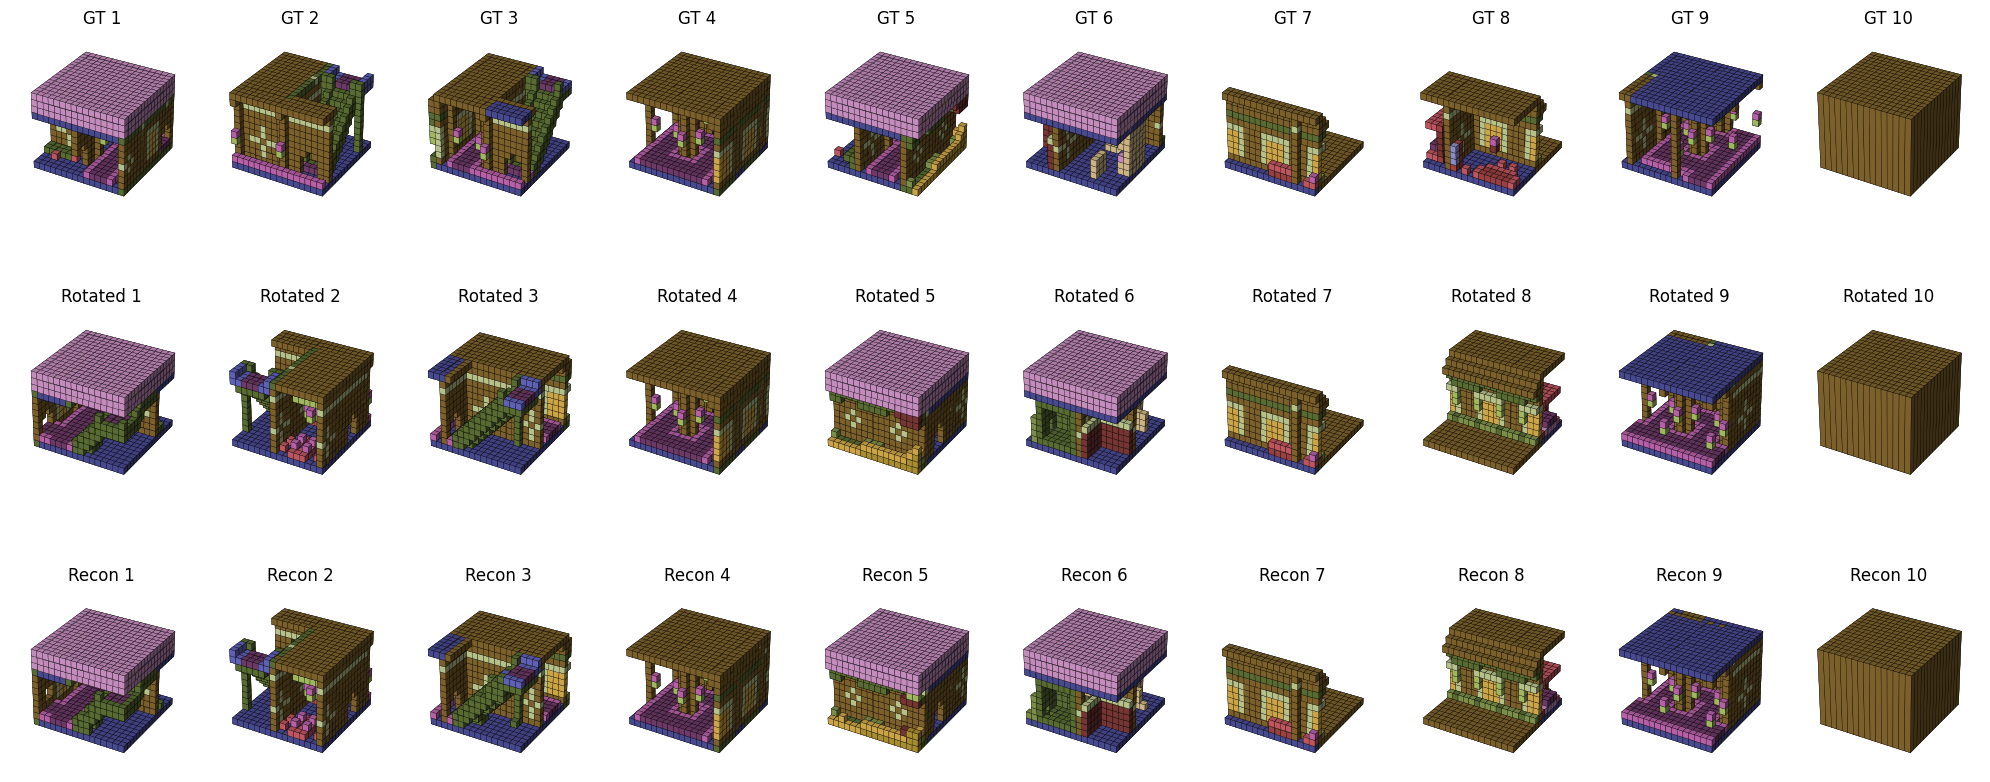

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ==== 加载模型 ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=16,
    feat_channel_up=16,
    mlp_hidden_channels=64,
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)
model.load_state_dict(torch.load("ae_triplane_epoch20.pt", map_location=device))
model.eval()

# ==== 可视化工具 ====
def visualize_voxel(ax, label, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # XZY
    filled = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~filled] = [0, 0, 0, 0]
    ax.voxels(filled, facecolors=facecolors, edgecolor='k', linewidth=0.2)
    ax.set_title(title)
    ax.axis('off')

# ==== 加载随机 patch，重建并可视化 ====
paths = list(Path("dataset").rglob("patch_*.npy"))
samples = np.random.choice(paths, size=10, replace=False)

fig = plt.figure(figsize=(20, 9))  # 增高一行

for i, path in enumerate(samples):
    voxel = np.load(path)

    # === 原始 ===
    ax1 = fig.add_subplot(3, 10, i + 1, projection='3d')
    visualize_voxel(ax1, voxel, f"GT {i+1}")

    # === 随机旋转（绕 y） ===
    k = np.random.randint(0, 4)
    rotated = np.rot90(voxel, k=k, axes=(0, 2)).copy()

    ax2 = fig.add_subplot(3, 10, i + 1 + 10, projection='3d')
    visualize_voxel(ax2, rotated, f"Rotated {i+1}")

    # === 编码后解码 ===
    vox_tensor = torch.tensor(rotated, dtype=torch.long).unsqueeze(0).to(device)

    D, H, W = 16, 12, 16
    coords = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, D),
        torch.linspace(-1, 1, H),
        torch.linspace(-1, 1, W),
        indexing='ij'), dim=-1).reshape(-1, 3).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(vox_tensor, coords)
        pred = logits.argmax(dim=-1).view(D, H, W).cpu().numpy()

    ax3 = fig.add_subplot(3, 10, i + 1 + 20, projection='3d')
    visualize_voxel(ax3, pred, f"Recon {i+1}")

plt.tight_layout()
plt.show()


In [16]:
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
import os

# === 加载训练好的模型 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=16,
    feat_channel_up=16,
    mlp_hidden_channels=64,
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)

model.load_state_dict(torch.load("ae_triplane_epoch20.pt", map_location=device))
model.eval()

# === 生成保存路径（保持原始结构） ===
def construct_save_path(base_input_path, base_output_path, input_file, rotation_id):
    relative_path = input_file.relative_to(base_input_path)
    filename = relative_path.stem + f"_rot{rotation_id}.pt"
    return base_output_path / relative_path.parent / filename

# === 扫描数据集 ===
input_root = Path("dataset")
output_root = Path("triplane_latent")
all_files = sorted(list(input_root.rglob("patch_*.npy")))

# === 遍历每个 patch，四次旋转保存 ===
for file in tqdm(all_files, desc="🔄 Saving Triplane Latents"):
    voxel = np.load(file)  # [16, 12, 16]
    for k in range(4):
        rotated = np.rot90(voxel, k=k, axes=(0, 2)).copy()
        vox_tensor = torch.tensor(rotated, dtype=torch.long).unsqueeze(0).to(device)

        with torch.no_grad():
            triplanes = model.encode(vox_tensor)  # list of 3 (B, C, H, W)

        # 检查 shape 是否为 [(1, 16, 8, 12), (1, 16, 8, 8), (1, 16, 12, 8)]
        shapes = [t.shape for t in triplanes]
        assert shapes == [(1, 16, 8, 12), (1, 16, 8, 8), (1, 16, 12, 8)], f"Shape mismatch: {shapes}"

        save_path = construct_save_path(input_root, output_root, file, k)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(triplanes, save_path)


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_21420\3877004294.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ae_triplane_epoch20.pt", 

✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_21420\3441110888.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ae_triplane_epoch20.pt", 

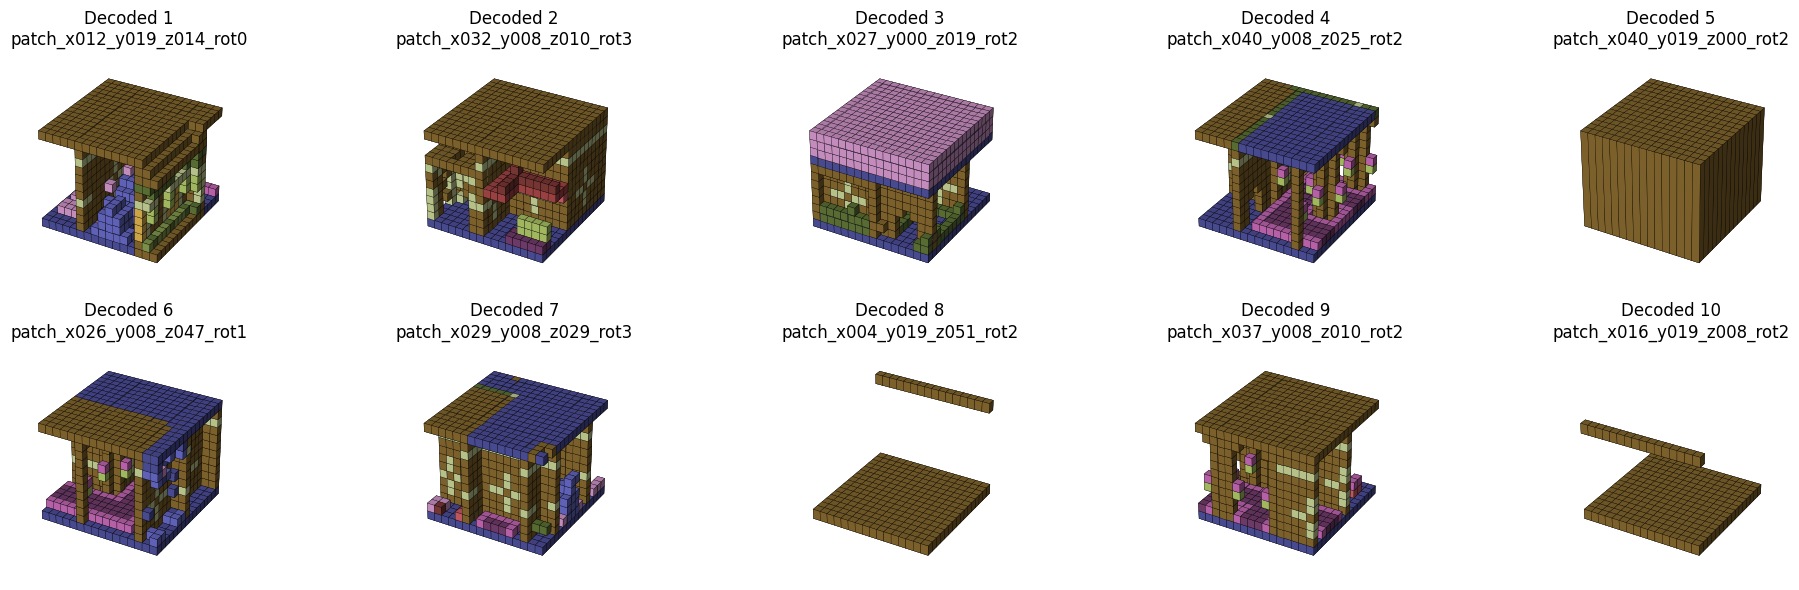

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === 加载模型 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=16,
    feat_channel_up=16,
    mlp_hidden_channels=64,
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)

model.load_state_dict(torch.load("ae_triplane_epoch20.pt", map_location=device))
model.eval()

# === 可视化 voxel 工具 ===
def visualize_voxel(ax, label, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # XZY
    filled = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~filled] = [0, 0, 0, 0]
    ax.voxels(filled, facecolors=facecolors, edgecolor='k', linewidth=0.2)
    ax.set_title(title)
    ax.axis('off')

# === 构建 query 网格 ===
def create_query_grid(D=16, H=12, W=16):
    coords = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, D),
        torch.linspace(-1, 1, H),
        torch.linspace(-1, 1, W),
        indexing='ij'), dim=-1).reshape(-1, 3)
    return coords.unsqueeze(0)  # [1, D*H*W, 3]

# === 随机加载 Triplane Latent 并可视化 ===
latent_root = Path("triplane_latent")
all_latent_paths = list(latent_root.rglob("*.pt"))
samples = np.random.choice(all_latent_paths, size=10, replace=False)

fig = plt.figure(figsize=(20, 6))
query = create_query_grid().to(device)

for i, path in enumerate(samples):
    triplane = torch.load(path, map_location=device)
    with torch.no_grad():
        logits = model.decode(triplane, query)  # [1, N, C]
        pred = logits.argmax(dim=-1).view(16, 12, 16).cpu().numpy()

    ax = fig.add_subplot(2, 5, i+1, projection='3d')
    visualize_voxel(ax, pred, f"Decoded {i+1}\n{path.stem}")

plt.tight_layout()
plt.show()


In [28]:
import torch
import torch.nn as nn
import numpy as np
import os
from pathlib import Path

# Define GaussianDiffusion class with padding and unpadding
class GaussianDiffusion:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.device = device
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise

    def pad_triplane(self, planes):
        xy, xz, yz = planes
        xy_pad = F.pad(xy, (0, 0, 0, 4))  # [B, C, 8, 12] → [B, C, 12, 12]
        xz_pad = F.pad(xz, (0, 4, 0, 4))  # [B, C, 8, 8] → [B, C, 12, 12]
        yz_pad = F.pad(yz, (0, 4, 0, 0))  # [B, C, 12, 8] → [B, C, 12, 12]
        return xy_pad, xz_pad, yz_pad

    def unpad_triplane(self, planes):
        xy, xz, yz = planes
        xy_unpad = xy[:, :, :8, :]     # [B, C, 12, 12] → [B, C, 8, 12]
        xz_unpad = xz[:, :, :8, :8]    # [B, C, 12, 12] → [B, C, 8, 8]
        yz_unpad = yz[:, :, :, :8]     # [B, C, 12, 12] → [B, C, 12, 8]
        return xy_unpad, xz_unpad, yz_unpad
    def sample(self, model, shape):
        """
        从标准高斯开始，逐步去噪，生成 latent。
        shape: (B, 3C, 12, 12) → 输出 fused triplane latent
        """
        B, C_total, H, W = shape
        x = torch.randn(B, C_total, H, W, device=self.device)

        for t in reversed(range(self.timesteps)):
            t_tensor = torch.full((B,), t, device=self.device, dtype=torch.float32)
            
            # === 解开为三个平面 ===
            tpl_xy, tpl_xz, tpl_yz = decompose_triplane_channelwise(x, sizes=(12, 12, 12))

            # === 模型预测噪声 ===
            noise_pred = model(tpl_xy, tpl_xz, tpl_yz, t_tensor) 

            beta_t = self.betas[t]
            alpha_t = self.alphas[t]
            alpha_bar_t = self.alpha_bars[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = (1 / alpha_t.sqrt()) * (
                x - (1 - alpha_t) / (1 - alpha_bar_t).sqrt() * noise_pred
            ) + beta_t.sqrt() * noise

        return x

# Simulate loading one sample from directory
# root_dir = "triplane_latent"
# paths = list(Path(root_dir).rglob("*.pt"))

# if len(paths) == 0:
#     result = "No triplane .pt files found."
# else:
#     sample_path = paths[0]
#     triplane = torch.load(sample_path)
#     xy, xz, yz = triplane  # each is expected shape: [1, 16, *, *]

#     diffusion = GaussianDiffusion(device="cpu")
#     padded = diffusion.pad_triplane((xy, xz, yz))
#     unpadded = diffusion.unpad_triplane(padded)

#     # Check shapes
#     original_shapes = (xy.shape, xz.shape, yz.shape)
#     padded_shapes = tuple(p.shape for p in padded)
#     unpadded_shapes = tuple(p.shape for p in unpadded)
#     shapes_match = all(o == u for o, u in zip(original_shapes, unpadded_shapes))

#     result = {
#         "sample_path": str(sample_path),
#         "original_shapes": original_shapes,
#         "padded_shapes": padded_shapes,
#         "unpadded_shapes": unpadded_shapes,
#         "shapes_match_after_unpad": shapes_match
#     }

# result


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_20632\4026638789.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ae_triplane_epoch20.pt", 


📦 Raw shapes in patch_x051_y000_z031_rot3.pt:
   XY: torch.Size([1, 16, 8, 12]) XZ: torch.Size([1, 16, 8, 8]) YZ: torch.Size([1, 16, 12, 8])
   XYpad: torch.Size([1, 16, 12, 12]) XZpad: torch.Size([1, 16, 12, 12]) YZpad: torch.Size([1, 16, 12, 12])
🔄 Unpadded shapes:
   XY: torch.Size([1, 16, 8, 12]) XZ: torch.Size([1, 16, 8, 8]) YZ: torch.Size([1, 16, 12, 8])
✅ Unpadding content matches original.

📦 Raw shapes in patch_x036_y000_z029_rot1.pt:
   XY: torch.Size([1, 16, 8, 12]) XZ: torch.Size([1, 16, 8, 8]) YZ: torch.Size([1, 16, 12, 8])
   XYpad: torch.Size([1, 16, 12, 12]) XZpad: torch.Size([1, 16, 12, 12]) YZpad: torch.Size([1, 16, 12, 12])
🔄 Unpadded shapes:
   XY: torch.Size([1, 16, 8, 12]) XZ: torch.Size([1, 16, 8, 8]) YZ: torch.Size([1, 16, 12, 8])
✅ Unpadding content matches original.

📦 Raw shapes in patch_x025_y000_z004_rot0.pt:
   XY: torch.Size([1, 16, 8, 12]) XZ: torch.Size([1, 16, 8, 8]) YZ: torch.Size([1, 16, 12, 8])
   XYpad: torch.Size([1, 16, 12, 12]) XZpad: torch.Siz

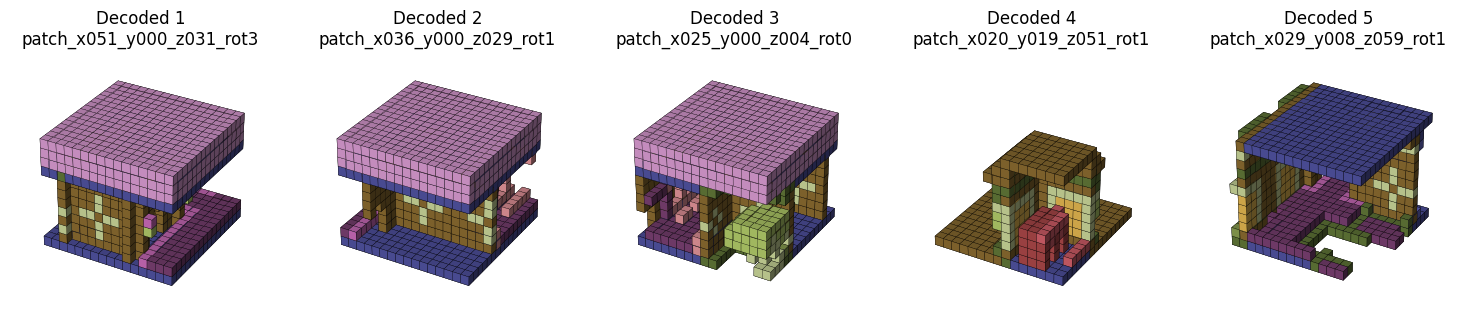

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === 加载模型 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=16,
    feat_channel_up=16,
    mlp_hidden_channels=64,
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)

model.load_state_dict(torch.load("ae_triplane_epoch20.pt", map_location=device))
model.eval()


def visualize_voxel(ax, label, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # XZY
    filled = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~filled] = [0, 0, 0, 0]
    ax.voxels(filled, facecolors=facecolors, edgecolor='k', linewidth=0.2)
    ax.set_title(title)
    ax.axis('off')

# === 构建 query 网格 ===
def create_query_grid(D=16, H=12, W=16):
    coords = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, D),
        torch.linspace(-1, 1, H),
        torch.linspace(-1, 1, W),
        indexing='ij'), dim=-1).reshape(-1, 3)
    return coords.unsqueeze(0)  # [1, D*H*W, 3]

# === 执行可视化 ===
diff = GaussianDiffusion(device=device)

latent_root = Path("triplane_latent")
all_latent_paths = list(latent_root.rglob("*.pt"))
samples = np.random.choice(all_latent_paths, size=5, replace=False)

fig = plt.figure(figsize=(15, 6))
query = create_query_grid().to(device)

for i, path in enumerate(samples):
    xy, xz, yz = torch.load(path, map_location=device)  # already [1, C, H, W]
    print(f"\n📦 Raw shapes in {path.name}:")
    print("   XY:", xy.shape, "XZ:", xz.shape, "YZ:", yz.shape)

    # 🛠 不再 unsqueeze(0)
    xy_pad, xz_pad, yz_pad = diff.pad_triplane((xy, xz, yz))
    print("   XYpad:", xy_pad.shape, "XZpad:", xz_pad.shape, "YZpad:", yz_pad.shape)
    xy_unpad, xz_unpad, yz_unpad = diff.unpad_triplane((xy_pad, xz_pad, yz_pad))

    print("🔄 Unpadded shapes:")
    print("   XY:", xy_unpad.shape, "XZ:", xz_unpad.shape, "YZ:", yz_unpad.shape)

    # 检查内容是否一致
    def same(a, b):
        return torch.allclose(a, b, atol=1e-6)

    if same(xy, xy_unpad) and same(xz, xz_unpad) and same(yz, yz_unpad):
        print("✅ Unpadding content matches original.")
    else:
        print("❌ Unpadding content mismatch!")

    triplane_unpad = [xy_unpad.to(device), xz_unpad.to(device), yz_unpad.to(device)]

    with torch.no_grad():
        logits = model.decode(triplane_unpad, query)  # [1, N, 31]
        pred = logits.argmax(dim=-1).view(16, 12, 16).cpu().numpy()

    ax = fig.add_subplot(2, 5, i + 1, projection='3d')
    visualize_voxel(ax, pred, f"Decoded {i + 1}\n{path.stem}")

plt.tight_layout()
plt.show()


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 时间嵌入 ---
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=t.device) * (-torch.log(torch.tensor(10000.0)) / half_dim))
        emb = t[:, None].float() * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

# --- 单个卷积 block ---
class TriplaneBasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_ch):
        super().__init__()
        self.norm = nn.BatchNorm2d(in_ch)
        self.act = nn.SiLU()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.emb_proj = nn.Linear(emb_ch, out_ch)

    def forward(self, x, emb):
        x = self.conv(self.act(self.norm(x)))
        emb_out = self.emb_proj(emb).unsqueeze(-1).unsqueeze(-1)
        return x + emb_out

# --- Triplane UNet ---


class TriplaneUNet(nn.Module):
    def __init__(self, in_ch=16, base_ch=32, emb_ch=64):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, emb_ch),
            nn.SiLU(),
            nn.Linear(emb_ch, emb_ch),
            nn.SiLU(),
        )

        self.enc_xy = TriplaneBasicBlock(in_ch, base_ch, emb_ch)
        self.enc_xz = TriplaneBasicBlock(in_ch, base_ch, emb_ch)
        self.enc_yz = TriplaneBasicBlock(in_ch, base_ch, emb_ch)

        self.mid_xy = TriplaneBasicBlock(base_ch, base_ch, emb_ch)
        self.mid_xz = TriplaneBasicBlock(base_ch, base_ch, emb_ch)
        self.mid_yz = TriplaneBasicBlock(base_ch, base_ch, emb_ch)

        self.dec_xy = TriplaneBasicBlock(base_ch, in_ch, emb_ch)
        self.dec_xz = TriplaneBasicBlock(base_ch, in_ch, emb_ch)
        self.dec_yz = TriplaneBasicBlock(base_ch, in_ch, emb_ch)

    def forward(self, tpl_xy, tpl_xz, tpl_yz, t):
        if t.dim() == 1:
            t = t[:, None]  # Make it [B, 1]
        emb = self.time_embed(t)

        x_xy = self.enc_xy(tpl_xy, emb)
        x_xz = self.enc_xz(tpl_xz, emb)
        x_yz = self.enc_yz(tpl_yz, emb)

        x_xy = self.mid_xy(x_xy, emb)
        x_xz = self.mid_xz(x_xz, emb)
        x_yz = self.mid_yz(x_yz, emb)

        x_xy = self.dec_xy(x_xy, emb)
        x_xz = self.dec_xz(x_xz, emb)
        x_yz = self.dec_yz(x_yz, emb)

        # 🔁 合并为单个 4D tensor
        output, _ = compose_triplane_channelwise([x_xy, x_xz, x_yz])  # [B, 3C, H*, W*]
        return output


In [5]:
from torch.utils.data import Dataset
from pathlib import Path
import torch

class TriplaneLatentDataset(Dataset):
    def __init__(self, root):
        self.paths = list(Path(root).rglob("*.pt"))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        xy, xz, yz = torch.load(self.paths[idx])
        return xy, xz, yz


In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# === 模型和Diffusion初始化 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TriplaneUNet(in_ch=16, base_ch=32, emb_ch=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
diff = GaussianDiffusion(device=device)

# === 数据 ===
dataset = TriplaneLatentDataset("triplane_latent")  # 你自己的数据集
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# === 训练 ===
# for epoch in range(10):
#     model.train()
#     total_loss = 0
#     pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", dynamic_ncols=True)

#     for batch in pbar:
#         xy, xz, yz = [x.to(device) for x in batch]  # Each: [B, C, H, W]

#         # === pad → compose
#         xy_pad, xz_pad, yz_pad = diff.pad_triplane((xy, xz, yz))  # [B, C, 12, 12]
#         xy_pad = xy_pad.squeeze(1)
#         xz_pad = xz_pad.squeeze(1)
#         yz_pad = yz_pad.squeeze(1)
#         x_start, _ = compose_triplane_channelwise([xy_pad, xz_pad, yz_pad])  # [B, 3C, 12, 12]

#         B, C_total, H, W = x_start.shape
#         noise = torch.randn(B, C_total, H, W, device=device)
#         t = torch.randint(0, diff.timesteps, (B,), device=device)
#         t_in = t.float()

#         x_noisy = diff.q_sample(x_start, t, noise=noise)
#         tpl_xy, tpl_xz, tpl_yz = decompose_triplane_channelwise(x_noisy, sizes=(12, 12, 12))

#         noise_pred = model(tpl_xy, tpl_xz, tpl_yz, t_in)

#         loss = loss_fn(noise_pred, noise)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         pbar.set_postfix(loss=loss.item())

#     # === 保存模型 ===
#     torch.save(model.state_dict(), f"triplane_unet_epoch{epoch+1}.pt")
#     print(f"✅ Epoch {epoch+1} done. Avg Loss: {total_loss / len(train_loader):.4f}")


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_20632\2945963491.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae.load_state_dict(torch.load("ae_triplane_epoch20.pt", map

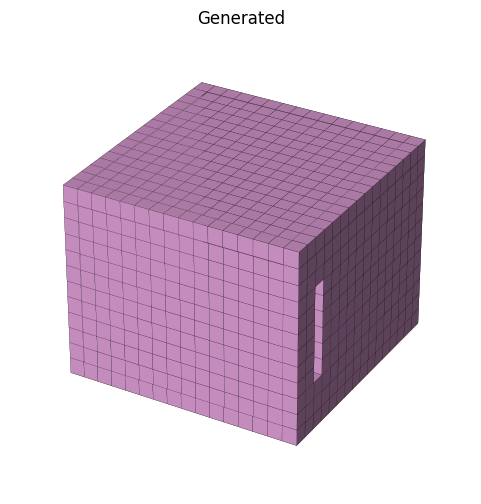

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# === 初始化 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# === 从噪声采样 ===
with torch.no_grad():
    B = 1
    C = 16
    shape = (B, 3 * C, 12, 12)  # [B, 48, 12, 12]
    x = torch.randn(shape, device=device)  # 初始噪声

    for t in reversed(range(diff.timesteps)):
        t_tensor = torch.full((B,), t, device=device, dtype=torch.float32)
        tpl_xy, tpl_xz, tpl_yz = decompose_triplane_channelwise(x, sizes=(12, 12, 12))
        noise_pred = model(tpl_xy, tpl_xz, tpl_yz, t_tensor)

        beta_t = diff.betas[t]
        alpha_t = diff.alphas[t]
        alpha_bar_t = diff.alpha_bars[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = (1 / alpha_t.sqrt()) * (
            x - (1 - alpha_t) / (1 - alpha_bar_t).sqrt() * noise_pred
        ) + beta_t.sqrt() * noise

    x_0 = x  # 最终结果

# === 解码 → 可视化 ===
tpl_xy, tpl_xz, tpl_yz = decompose_triplane_channelwise(x_0, sizes=(12, 12, 12))
tpl_xy = tpl_xy.unsqueeze(1)  # [1, 1, C, H, W]
tpl_xz = tpl_xz.unsqueeze(1)
tpl_yz = tpl_yz.unsqueeze(1)

from pathlib import Path

# 使用训练好的 AutoEncoder decoder
ae = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=16,
    feat_channel_up=16,
    mlp_hidden_channels=64,
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)
ae.load_state_dict(torch.load("ae_triplane_epoch20.pt", map_location=device))
ae.eval()

query = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, 16),
    torch.linspace(-1, 1, 12),
    torch.linspace(-1, 1, 16),
    indexing='ij'), dim=-1).reshape(1, -1, 3).to(device)

with torch.no_grad():
    pred = ae.decode([tpl_xy[0].to(device), tpl_xz[0].to(device), tpl_yz[0].to(device)], query)
    pred_label = pred.argmax(dim=-1).view(16, 12, 16).cpu().numpy()

# === 可视化 voxel ===
def visualize_voxel(label, title="Generated"):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # XZY
    filled = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~filled] = [0, 0, 0, 0]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(filled, facecolors=facecolors, edgecolor='k', linewidth=0.1)
    ax.set_title(title)
    ax.axis('off')
    plt.show()

visualize_voxel(pred_label)


In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

# === 模型和Diffusion初始化 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TriplaneUNet(in_ch=16, base_ch=32, emb_ch=64).to(device)
model.load_state_dict(torch.load("triplane_unet_epoch19.pt", map_location=device))  # 加载旧权重

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=18,eta_min=1e-6)
loss_fn = nn.MSELoss()
diff = GaussianDiffusion(device=device)

# === 数据 ===
dataset = TriplaneLatentDataset("triplane_latent")
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# # === 继续训练 18 个 epoch ===
for epoch in range(3, 21):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}", dynamic_ncols=True)

    for batch in pbar:
        xy, xz, yz = [x.to(device) for x in batch]  # Each: [B, C, H, W]

        # === pad → compose
        xy_pad, xz_pad, yz_pad = diff.pad_triplane((xy, xz, yz))  # [B, C, 12, 12]
        xy_pad = xy_pad.squeeze(1)
        xz_pad = xz_pad.squeeze(1)
        yz_pad = yz_pad.squeeze(1)
        x_start, _ = compose_triplane_channelwise([xy_pad, xz_pad, yz_pad])  # [B, 3C, 12, 12]

        B, C_total, H, W = x_start.shape
        noise = torch.randn(B, C_total, H, W, device=device)
        t = torch.randint(0, diff.timesteps, (B,), device=device)
        t_in = t.float()

        x_noisy = diff.q_sample(x_start, t, noise=noise)
        tpl_xy, tpl_xz, tpl_yz = decompose_triplane_channelwise(x_noisy, sizes=(12, 12, 12))
        noise_pred = model(tpl_xy, tpl_xz, tpl_yz, t_in)

        loss = loss_fn(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        avg_loss = total_loss / (pbar.n + 1)
        pbar.set_description(f"Epoch {epoch} (avg: {avg_loss:.4f})")
        pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

    scheduler.step()
    torch.save(model.state_dict(), f"triplane_unet_epoch{epoch}.pt")
    print(f"✅ Epoch {epoch} done. Avg Loss: {total_loss / len(train_loader):.4f}")


C:\Users\Admin\AppData\Local\Temp\ipykernel_20632\238294332.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("triplane_unet_epoch19.pt",

KeyboardInterrupt: 

✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_20632\148696327.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae.load_state_dict(torch.load("ae_triplane_epoch2.pt", map_l

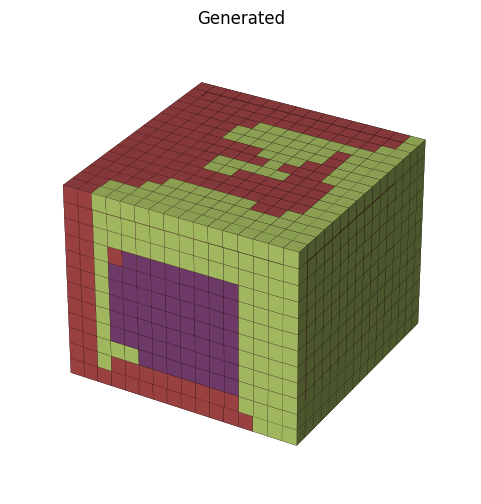

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# === 初始化 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# === 从噪声采样 ===
with torch.no_grad():
    B = 1
    C = 16
    shape = (B, 3 * C, 12, 12)  # [B, 48, 12, 12]
    x = torch.randn(shape, device=device)  # 初始噪声

    for t in reversed(range(diff.timesteps)):
        t_tensor = torch.full((B,), t, device=device, dtype=torch.float32)
        tpl_xy, tpl_xz, tpl_yz = decompose_triplane_channelwise(x, sizes=(12, 12, 12))
        noise_pred = model(tpl_xy, tpl_xz, tpl_yz, t_tensor)

        beta_t = diff.betas[t]
        alpha_t = diff.alphas[t]
        alpha_bar_t = diff.alpha_bars[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = (1 / alpha_t.sqrt()) * (
            x - (1 - alpha_t) / (1 - alpha_bar_t).sqrt() * noise_pred
        ) + beta_t.sqrt() * noise

    x_0 = x  # 最终结果

# === 解码 → 可视化 ===
tpl_xy, tpl_xz, tpl_yz = decompose_triplane_channelwise(x_0, sizes=(12, 12, 12))
tpl_xy = tpl_xy.unsqueeze(1)  # [1, 1, C, H, W]
tpl_xz = tpl_xz.unsqueeze(1)
tpl_yz = tpl_yz.unsqueeze(1)

from pathlib import Path

# 使用训练好的 AutoEncoder decoder
ae = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=16,
    feat_channel_up=16,
    mlp_hidden_channels=64,
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)
ae.load_state_dict(torch.load("ae_triplane_epoch2.pt", map_location=device))
ae.eval()

query = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, 16),
    torch.linspace(-1, 1, 12),
    torch.linspace(-1, 1, 16),
    indexing='ij'), dim=-1).reshape(1, -1, 3).to(device)

with torch.no_grad():
    pred = ae.decode([tpl_xy[0].to(device), tpl_xz[0].to(device), tpl_yz[0].to(device)], query)
    pred_label = pred.argmax(dim=-1).view(16, 12, 16).cpu().numpy()

# === 可视化 voxel ===/
def visualize_voxel(label, title="Generated"):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # XZY
    filled = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~filled] = [0, 0, 0, 0]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(filled, facecolors=facecolors, edgecolor='k', linewidth=0.1)
    ax.set_title(title)
    ax.axis('off')
    plt.show()

visualize_voxel(pred_label)


✅ Building encoder...
✅ Building triplane conv...
✅ Building decoder...


C:\Users\Admin\AppData\Local\Temp\ipykernel_20632\2469087906.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("ae_triplane_epoch20.pt", ma

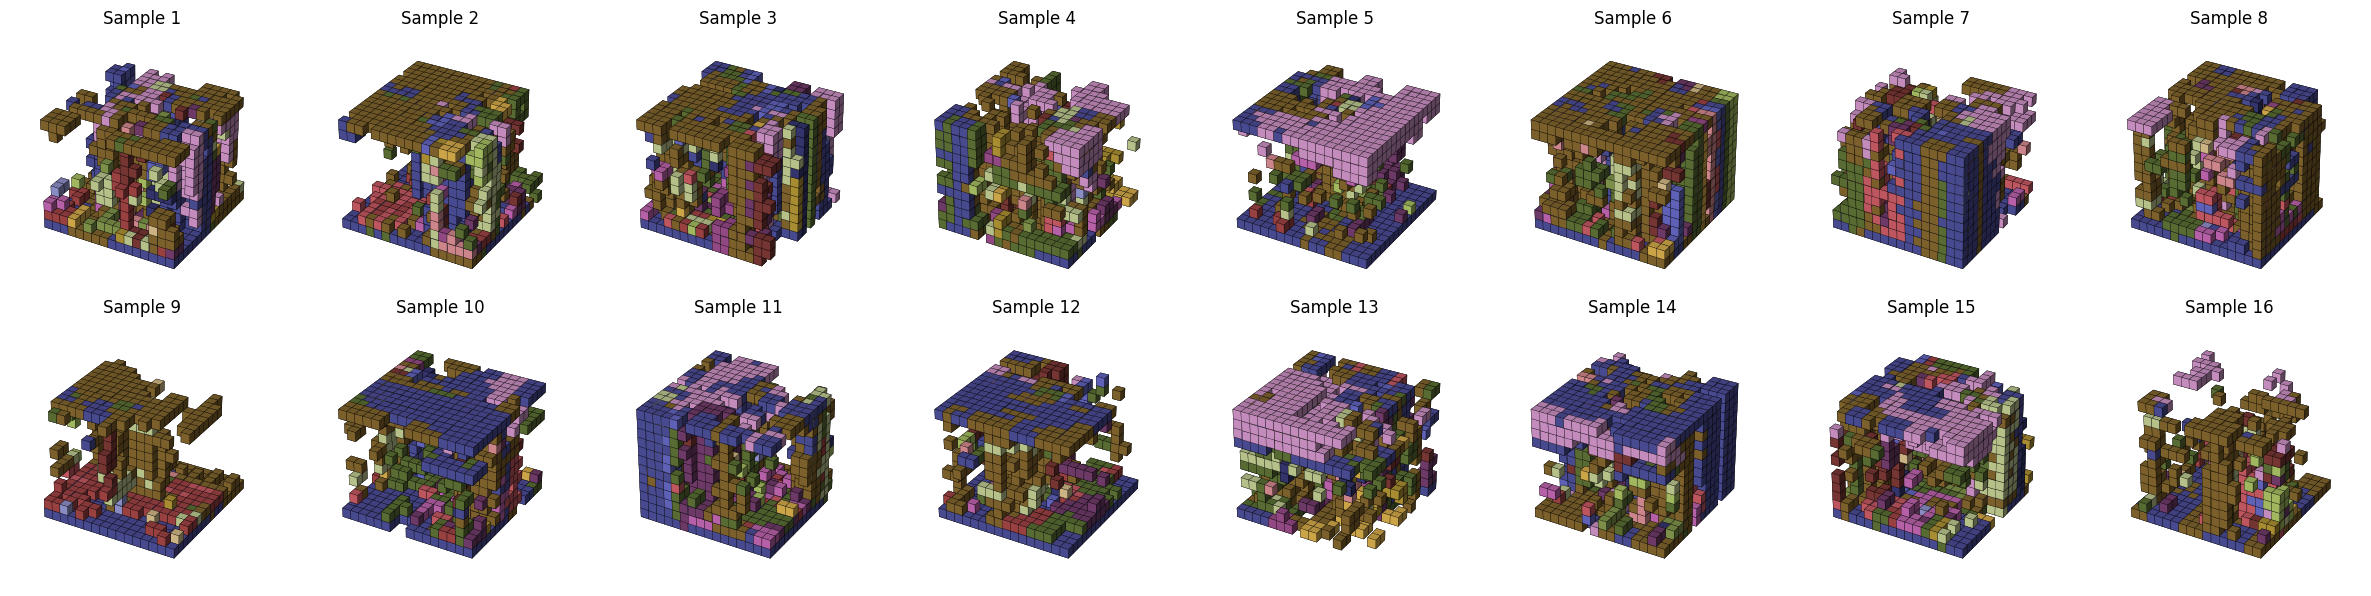

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# # ==== 导入模型类 ====
# from your_model_library import AutoEncoderGroupSkip, TriplaneUNet, GaussianDiffusion
# from your_model_library import decompose_triplane_channelwise, unpad_triplane  # ← 确保你定义了这些

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== 加载 AutoEncoder ====
vae = AutoEncoderGroupSkip(
    num_class=31,
    geo_feat_channels=16,
    feat_channel_up=16,
    mlp_hidden_channels=64,
    mlp_hidden_layers=4,
    z_down=False,
    use_posenc=True,
).to(device)
vae.load_state_dict(torch.load("ae_triplane_epoch20.pt", map_location=device))
vae.eval()

# ==== 加载 Diffusion 模型 ====
diff_model = TriplaneUNet(in_ch=16, base_ch=32, emb_ch=64).to(device)
diff_model.load_state_dict(torch.load("triplane_unet_epoch17.pt", map_location=device))
diff_model.eval()

# ==== 初始化 Diffusion ====
diffusion = GaussianDiffusion(timesteps=1000, device=device)

# ==== 可视化工具 ====
def visualize_voxel(ax, label, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # XZY
    filled = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~filled] = [0, 0, 0, 0]
    ax.voxels(filled, facecolors=facecolors, edgecolor='k', linewidth=0.2)
    ax.set_title(title)
    ax.axis('off')

# ==== 从噪声采样 → decode → 可视化 ====
with torch.no_grad():
    shape = (16, 48, 12, 12)  # [B=16, 3*16, 12, 12]
    latent_noisy = diffusion.sample(diff_model, shape)

    # === 分解 → 去 pad ===
    tpl_xy, tpl_xz, tpl_yz = decompose_triplane_channelwise(latent_noisy, sizes=(12, 12, 12))
    tpl_xy, tpl_xz, tpl_yz = diffusion.unpad_triplane((tpl_xy, tpl_xz, tpl_yz))  # → [B, 16, ?, ?]

    # === decode each sample ===
    fig = plt.figure(figsize=(24, 6))
    for i in range(16):
        # 每个 decode 使用 query grid
        D, H, W = 16, 12, 16
        coords = torch.stack(torch.meshgrid(
            torch.linspace(-1, 1, D),
            torch.linspace(-1, 1, H),
            torch.linspace(-1, 1, W),
            indexing='ij'), dim=-1).reshape(-1, 3).unsqueeze(0).to(device)

        logits = vae.decode(
            [tpl_xy[i:i+1], tpl_xz[i:i+1], tpl_yz[i:i+1]], coords
        )  # [1, N, 31]
        pred = logits.argmax(dim=-1).view(16, 12, 16).cpu().numpy()

        ax = fig.add_subplot(2, 8, i + 1, projection='3d')
        visualize_voxel(ax, pred, f"Sample {i+1}")

    plt.tight_layout()
    plt.show()
